In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_epochs = 10
batch_size = 100
learning_rate = 0.001

# MNIST dataset
train_dataset = MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = MNIST(root='./data', train=False, transform=transforms.ToTensor())

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 54933725.55it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 26140633.11it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 31564999.53it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 782973.52it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
# Fully connected neural network (FCNN)
class FCNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Convolutional neural network (CNN)
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [4]:
# Initialize the models
input_size = 784
hidden_size = 500
num_classes = 10

fcnn_model = FCNN(input_size, hidden_size, num_classes).to(device)
cnn_model = CNN(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
fc_optimizer = optim.Adam(fcnn_model.parameters(), lr=learning_rate)
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)

In [5]:
# Training loop for FCNN
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = fcnn_model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        fc_optimizer.zero_grad()
        loss.backward()
        fc_optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

# Training loop for CNN
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        cnn_optimizer.zero_grad()
        loss.backward()
        cnn_optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

Epoch [1/10], Step [100/600], Loss: 0.4132
Epoch [1/10], Step [200/600], Loss: 0.3455
Epoch [1/10], Step [300/600], Loss: 0.2275
Epoch [1/10], Step [400/600], Loss: 0.2017
Epoch [1/10], Step [500/600], Loss: 0.0883
Epoch [1/10], Step [600/600], Loss: 0.2887
Epoch [2/10], Step [100/600], Loss: 0.1289
Epoch [2/10], Step [200/600], Loss: 0.1240
Epoch [2/10], Step [300/600], Loss: 0.1622
Epoch [2/10], Step [400/600], Loss: 0.1303
Epoch [2/10], Step [500/600], Loss: 0.0952
Epoch [2/10], Step [600/600], Loss: 0.0804
Epoch [3/10], Step [100/600], Loss: 0.0608
Epoch [3/10], Step [200/600], Loss: 0.0946
Epoch [3/10], Step [300/600], Loss: 0.1936
Epoch [3/10], Step [400/600], Loss: 0.0354
Epoch [3/10], Step [500/600], Loss: 0.0340
Epoch [3/10], Step [600/600], Loss: 0.0622
Epoch [4/10], Step [100/600], Loss: 0.0738
Epoch [4/10], Step [200/600], Loss: 0.0228
Epoch [4/10], Step [300/600], Loss: 0.0612
Epoch [4/10], Step [400/600], Loss: 0.0446
Epoch [4/10], Step [500/600], Loss: 0.0309
Epoch [4/10

In [6]:
# Test the models
fcnn_model.eval()
cnn_model.eval()
with torch.no_grad():
    correct_fcnn = 0
    total_fcnn = 0
    correct_cnn = 0
    total_cnn = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs_fcnn = fcnn_model(images)
        _, predicted_fcnn = torch.max(outputs_fcnn.data, 1)
        total_fcnn += labels.size(0)
        correct_fcnn += (predicted_fcnn == labels).sum().item()

        images = images.reshape(-1, 1, 28, 28).to(device)
        outputs_cnn = cnn_model(images)
        _, predicted_cnn = torch.max(outputs_cnn.data, 1)
        total_cnn += labels.size(0)
        correct_cnn += (predicted_cnn == labels).sum().item()

    print('FCNN Accuracy: {} %'.format(100 * correct_fcnn / total_fcnn))
    print('CNN Accuracy: {} %'.format(100 * correct_cnn / total_cnn))

# Save the best performing model
best_model = fcnn_model if (100 * correct_fcnn / total_fcnn) > (100 * correct_cnn / total_cnn) else cnn_model
torch.save(best_model.state_dict(), 'best_model.pth')

FCNN Accuracy: 97.99 %
CNN Accuracy: 99.05 %





----------------Contoured Image--------------------


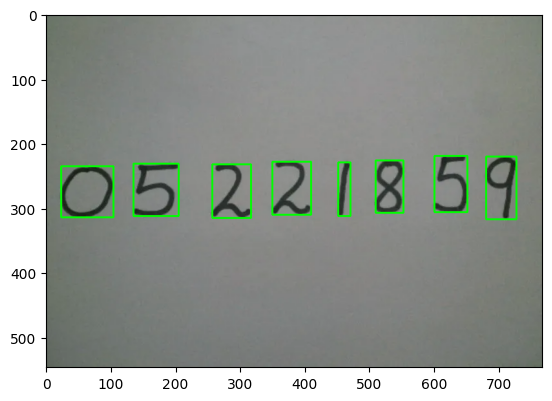

In [8]:
image = cv2.imread('/content/test_image.jpeg')
grey = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(grey.copy(), 75, 255, cv2.THRESH_BINARY_INV)
contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
preprocessed_digits = []
for c in contours:
    x,y,w,h = cv2.boundingRect(c)

    # Creating a rectangle around the digit in the original image (for displaying the digits fetched via contours)
    cv2.rectangle(image, (x,y), (x+w, y+h), color=(0, 255, 0), thickness=2)

    # Cropping out the digit from the image corresponding to the current contours in the for loop
    digit = thresh[y:y+h, x:x+w]

    # Resizing that digit to (18, 18)
    resized_digit = cv2.resize(digit, (18,18))

    # Padding the digit with 5 pixels of black color (zeros) in each side to finally produce the image of (28, 28)
    padded_digit = np.pad(resized_digit, ((5,5),(5,5)), "constant", constant_values=0)

    # Adding the preprocessed digit to the list of preprocessed digits
    preprocessed_digits.append(padded_digit)
print("\n\n\n----------------Contoured Image--------------------")
plt.imshow(image, cmap="gray")
plt.show()





---------------------------------------


=========PREDICTION============ 




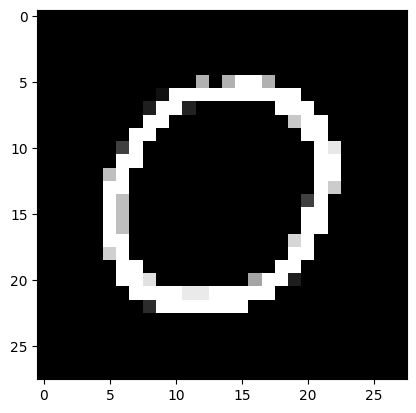



Final Output: 0

Prediction (Softmax) from the neural network:

 tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<SoftmaxBackward0>)


Hard-maxed form of the prediction: 

 tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


---------------------------------------




---------------------------------------


=========PREDICTION============ 




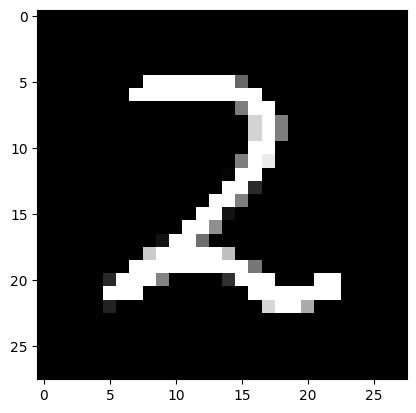



Final Output: 2

Prediction (Softmax) from the neural network:

 tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<SoftmaxBackward0>)


Hard-maxed form of the prediction: 

 tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])


---------------------------------------




---------------------------------------


=========PREDICTION============ 




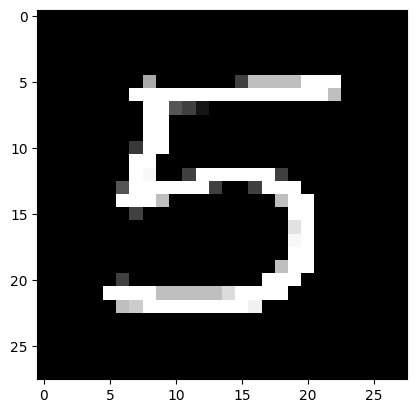



Final Output: 5

Prediction (Softmax) from the neural network:

 tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], grad_fn=<SoftmaxBackward0>)


Hard-maxed form of the prediction: 

 tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])


---------------------------------------




---------------------------------------


=========PREDICTION============ 




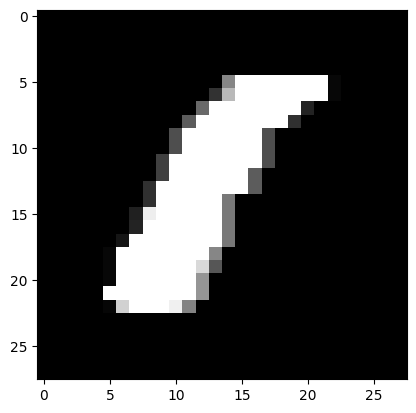



Final Output: 1

Prediction (Softmax) from the neural network:

 tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<SoftmaxBackward0>)


Hard-maxed form of the prediction: 

 tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])


---------------------------------------




---------------------------------------


=========PREDICTION============ 




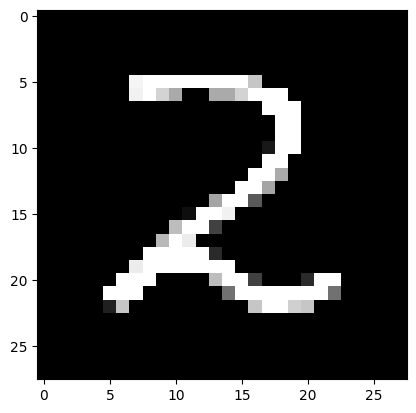



Final Output: 2

Prediction (Softmax) from the neural network:

 tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<SoftmaxBackward0>)


Hard-maxed form of the prediction: 

 tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])


---------------------------------------




---------------------------------------


=========PREDICTION============ 




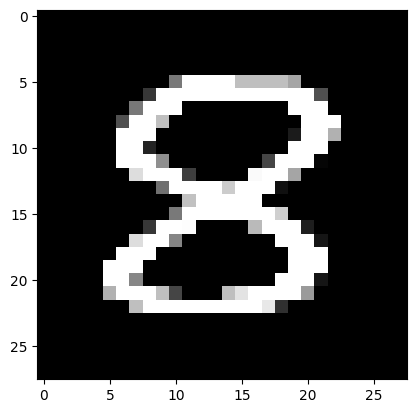



Final Output: 8

Prediction (Softmax) from the neural network:

 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], grad_fn=<SoftmaxBackward0>)


Hard-maxed form of the prediction: 

 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])


---------------------------------------




---------------------------------------


=========PREDICTION============ 




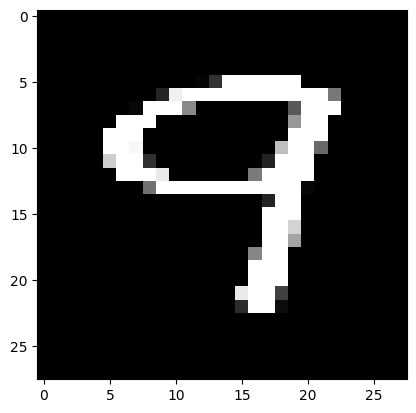



Final Output: 9

Prediction (Softmax) from the neural network:

 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], grad_fn=<SoftmaxBackward0>)


Hard-maxed form of the prediction: 

 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])


---------------------------------------




---------------------------------------


=========PREDICTION============ 




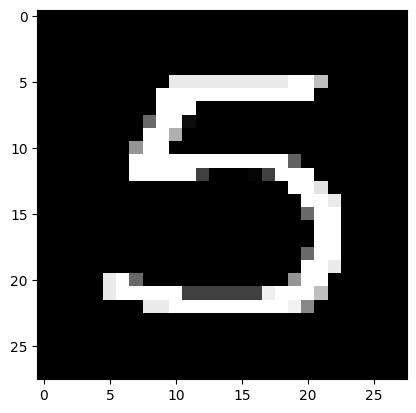



Final Output: 5

Prediction (Softmax) from the neural network:

 tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], grad_fn=<SoftmaxBackward0>)


Hard-maxed form of the prediction: 

 tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])


---------------------------------------




In [9]:
inp = np.array(preprocessed_digits)

# Create lists to store predictions, softmax outputs, and hard-maxed forms
all_predictions = []
all_softmax_outputs = []
all_hard_maxed_forms = []

best_model.eval()  # Put the model in evaluation mode

for idx, digit in enumerate(preprocessed_digits):
    digit_tensor = torch.from_numpy(digit).unsqueeze(0).unsqueeze(0).float().to(device)
    prediction = best_model(digit_tensor)

    softmax_output = nn.functional.softmax(prediction, dim=1)
    hard_maxed_prediction = torch.zeros_like(prediction)
    hard_maxed_prediction[0][prediction.argmax()] = 1

    # Append the prediction, softmax output, and hard-maxed form along with the index
    all_predictions.append((idx, prediction.argmax().item()))
    all_softmax_outputs.append((idx, softmax_output.detach().cpu().numpy()))
    all_hard_maxed_forms.append((idx, hard_maxed_prediction.detach().cpu().numpy()))

    print ("\n\n---------------------------------------\n\n")
    print ("=========PREDICTION============ \n\n")
    plt.imshow(digit.reshape(28, 28), cmap="gray")
    plt.show()
    print("\n\nFinal Output: {}".format(prediction.argmax().item()))

    print ("\nPrediction (Softmax) from the neural network:\n\n {}".format(softmax_output))

    print ("\n\nHard-maxed form of the prediction: \n\n {}".format(hard_maxed_prediction))
    print ("\n\n---------------------------------------\n\n")

